In [1]:
import numpy as np
from classfunctions import NbodyClass
import matplotlib.pyplot as mpl
from mpl_toolkits.mplot3d import Axes3D

In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplo

### Part 4

This method starts the universe where the particle density is generated from a k^-3 distribution.

First, I run a large k^-3 distribution and plot slices of it to demonstrate that it is functional. Then I generate a smaller distribution the same size as the grid I will use for my nbody run.

The k^-3 distribution is normalized to a probability between 0 and 1

The first 

TO DO:
- draw masses from the distribution
- adjust code to deal with masses better / at all

Matthew says:
- generate FFT
- add gaussian noise
- create a density grid to randomly sample points from based on prob dist.

- create 3D grid with k^-3 dependence
- apply inverse fourier transform
- get density map with k^-3 spatial dependence


Steps mimicking Garret Goon:
https://garrettgoon.com/gaussian-fields/
QUOTE:
 A realization of a Gaussian random field with power spectrum can be created via the following steps:

    Start with a white noise field with unit amplitude 

obeying
.
Generate a position space realization of the white noise, denoted by
. That is, is a particular map showing the values of at various positions and for which
.
Fourier transform the realization:
.
Multiply
by the square root of the power spectrum to create
.
Fourier transform
back to positio space to get the desired realization: .

In [2]:
def power_dist(num, DEBUG=False):
        dx = np.arange(num)            
        #making it wrap around. stuff in same column/row/depth will have 0
        #previous wraps around to -1, next goes to 1
        dx[num//2:] = dx[num//2:]-num
        if DEBUG:
            print('dx before multiplication by 2pi/num is ', dx)
        dx = 2*np.pi/num*dx # how it's done in garrett goon

        #distances away from particle in x, y, z
        #particle lives at 0, 0, 0
        xmesh, ymesh, zmesh = np.meshgrid(dx,dx,dx)
        if DEBUG:
            mpl.imshow(xmesh[0, :, :], cmap='hot')
            mpl.title('xmesh x=0 2D slice')
            mpl.colorbar()
            mpl.show()  
            
            mpl.imshow(xmesh[:, 0, :], cmap='hot')
            mpl.title('xmesh y=0 2D slice')
            mpl.colorbar()
            mpl.show()
            
            mpl.imshow(xmesh[:, :, 0], cmap='hot')
            mpl.title('xmesh x=0 2D slice')
            mpl.colorbar()
            mpl.show()   
        
        dr = np.sqrt(xmesh**2 + ymesh**2 + zmesh**2)

        #point at 0,0,0 is 0 and will blow up
        dr[0, 0, 0] = 1 #temporarily make it one
        k_map = dr**(-3) #create the square root of the power distribution
        k_map[0, 0, 0] = 0 #was temporarily made 1 to not explode
        
        if DEBUG:
#             print('dr x = 0 is \n ', dr[0, :, :])
            mpl.imshow(dr[0, :, :], cmap='hot')
            mpl.title('dr x=0 2D slice')
            mpl.show()    
        
#             print('k_map x = 0 is \n ', k_map[0, :, :])
#             print('k_map x = 5 is \n,', k_map[5, :, :])
            mpl.imshow(k_map[0, :, :], cmap='hot')
            mpl.title('kmap x=0 2D slice')
            mpl.show()

        return k_map

In [3]:
def generate_mass_fluctuations(num, DEBUG=False):
    
    #generate the intial power spectrum data
    norm_data = np.random.normal(size=(num, num, num))
#   norm_data = np.random.random((num, num, num))
    fft_dat = np.fft.fftn(norm_data)
    
    if DEBUG:
        mpl.figure()
        mpl.imshow(norm_data[0, :, :], cmap='hot')
        mpl.title('random noise 2D slice x=0')
        mpl.colorbar()
        mpl.show()

        mpl.figure()
        mpl.imshow(abs(fft_dat[0, :, :]), cmap='hot')
        mpl.title('abs of FT of random noise 2D slice x=0')
        mpl.colorbar()
        mpl.show()
        
        
    #get the power spectrum and multiply by the fourier space data
    pwr_spec = power_dist(num, DEBUG)
    
    fft_dat = fft_dat*pwr_spec
    dat = np.fft.ifftn(fft_dat)
    
    if DEBUG:
        mpl.figure()
        mpl.imshow(np.real(dat[5, :, :]), cmap='hot')
        mpl.title('real of FT of random noise 2D slice x=5')
        mpl.colorbar()
        mpl.show()
        
        mpl.figure()
        mpl.imshow(np.real(dat[:, 5, :]), cmap='hot')
        mpl.title('real of FT of random noise 2D slice y=5')
        mpl.colorbar()
        mpl.show()
        
    return np.real(dat)
        
def generate_start_poisitions(num, num_part, DEBUG=False):
    #first get the mass fluctuation grid
    flucs = generate_mass_fluctuations(num, DEBUG=False)
    flucs -= np.min(flucs)
    flucs/= np.max(flucs)
    
    if DEBUG:
        mpl.imshow(flucs[:, 5, :], cmap='hot')
        mpl.title('normalized fluctuations 2D slice y=5')
        mpl.colorbar()
        mpl.show()

    #sample the probability grid with particles. preference to keep those in the higher probability areas.
    #do this by: randomly creating particles, and a second random 'keep' vector. if the particle's 'keep'
    #index is within the probability of the cell where it winds up, keep it! if not, throw it out.
    
    #sample the grid with particles.
    x = num*np.random.rand(3, num_part)
#     print('x is ', x)
    keep = np.random.rand(num_part)
#     print('keep is ', keep)
    idx_keep = np.zeros(num_part, dtype=bool)
#     print('idx keep is ', idx_keep)
    
    x_idx = x.copy().astype(int)
#     print('x_idx', x_idx)
    
#     print('flucs shape', flucs.shape)
#     print('flux 000 ', flucs[0,0,0])
    
    for ii in range(num_part):
#         print('x index:', x_idx[:, ii])
        idx_keep[ii] = keep[ii] < flucs[x_idx[0, ii], x_idx[1, ii], x_idx[2, ii]]
#         print('keep', keep[ii])
#         print('flucs', flucs[x_idx[0, ii], x_idx[1, ii], x_idx[2, ii]])
        
#     print('idx keep', idx_keep)
    x_out = x[:, idx_keep]
    
    if DEBUG:
        print(num_part, ' particles started')
        print(x_out.shape[1], ' particles kept')
        print('max and min of flucs are ', np.max(flucs), np.min(flucs))
    
    return x_out

In [4]:
#TEST STUFF YAAAY plot a pretty, large picture

# num = 100
# num_part = 5*10**5
# x = generate_start_poisitions(num, num_part, DEBUG=True)
# print(x.shape)

In [5]:
#produce heat maps of the nbody density grid with the particles
#show that it looks like the heatmap of the normalized fluctuations, with a little extra randomness
#but need enough particles to see, plot with smaller spread.
# num_part = 10**6
# steps = 2
# spread = 20

# pos = generate_start_poisitions(spread, num_part, DEBUG=True)
# vel = np.zeros( (3, num_part) )

# nbody = NbodyClass(pos, vel, dt=0.1, sgrid=spread, periodic=True, gradient=True)
# nbody.update_grid()

# mpl.figure()
# mpl.imshow(nbody.grid[:, 5, :]/np.max(nbody.grid), cmap='hot')
# mpl.title('nbody grid y=5 2D slice')
# mpl.colorbar()
# mpl.show()

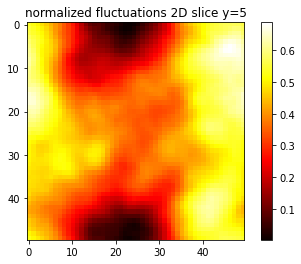

500000  particles started
261188  particles kept
max and min of flucs are  1.0 0.0


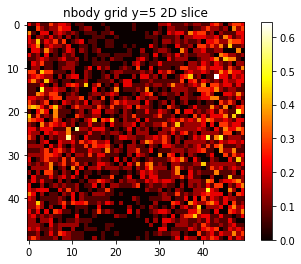

In [ ]:
#run nbody steps see what the universe will look like. use periodic boundary conditions
num_part = 5*10**5
spread=50
periodic = True
vzero = True
soft=4
n = 51


name_prefix = "grid" + str(spread) + "step" + str(n) + "soften" + str(soft)
if periodic:
    outdir = "part4Outputs/" + name_prefix + "/" + name_prefix
else:
    outdir = "part4Outputs/" + name_prefix + "/" + name_prefix


pos = generate_start_poisitions(spread, num_part, DEBUG=True)
if vzero:
    v = np.zeros( (3, pos.shape[1]) )
else:
    v = np.random.rand(3, pos.shape[1])
    
#instantiate the class
nbody = NbodyClass(pos, v, outdir=outdir, sgrid=spread, periodic=periodic, gradient=False, soft=soft)
nbody.calculate_potential(DEBUG=False)

#display initial density grid
mpl.figure()
mpl.imshow(nbody.grid[:, 5, :]/np.max(nbody.grid), cmap='hot')
mpl.title('nbody grid y=5 2D slice')
mpl.colorbar()
mpl.show()

nbody.take_n_steps(n, plots=True, plot_every=1)

In [ ]:
print('Run specs: ')
print('Periodic: ', periodic)
print('Grid cells: ', spread)
print('Number of particles: ', num_part)
print('Number of steps: ', n)
print('Velocities start at zero :', vzero)
print('Softening: ', soft)

readme = outdir+ "readme.txt"
print('printing to readme file ...', readme)
f = open(readme, "w")
f.write('Run specs:')
f.write('\nPeriodic: ' + str(periodic))
f.write('\nGrid cells: ' + str(spread))
f.write('\nNumber of particles: ' + str(num_part))
f.write('\nNumber selected: ' + str(pos.shape[1]))
f.write('\nNumber of steps: ' + str(n))
f.write('\nVelocities start at zero :' +  str(vzero))
f.write('\nSoftening: ' + str(soft))
f.close()

In [ ]:
#plot the energy, see how well it's conserved
# nbody.plot_energy()
lims = 25

mpl.figure()
# mpl.plot(range(0, n), nbody.pe[:n])
mpl.plot(range(0, n), nbody.ke[0, :n])
mpl.plot(range(0, n), nbody.ke[1, :n])
mpl.plot(range(0, n), nbody.ke[2, :n])
# mpl.plot(range(0, n), nbody.pe[:n] + np.sum(nbody.ke, axis=0)[:n])
mpl.legend(['keX', 'keY', 'keZ'])
mpl.title('energy')
# mpl.xlim([0, lims])
mpl.show()

mpl.figure()
mpl.plot(range(0, n), nbody.pe[:n])
# mpl.plot(range(0, n), nbody.ke[0, :n])
# mpl.plot(range(0, n), nbody.ke[1, :n])
# mpl.plot(range(0, n), nbody.ke[2, :n])
mpl.plot(range(0, n), nbody.pe[:n] + np.sum(nbody.ke, axis=0)[:n])
mpl.legend(['Pot', 'tot e'])
# mpl.legend(['Pot', 'keX', 'keY', 'keZ', 'tot e'])
# mpl.xlim([0, lims])
mpl.title('energy')
mpl.show()

np.save(outdir + 'kinen', nbody.ke)
np.save(outdir + 'poten', nbody.pe)